In [1]:
import importlib
from typing import Dict, Tuple
from matplotlib import pyplot as plt
from shared.definitions import TuningResult
from shared.ml_config_core import ModelTrainingResult
from shared import stats_utils
from shared.ml_config_runner import build_production_model_for_tuning_result
from shared import graph
from shared import utils
import seaborn as sns
import pandas as pd
import xgboost
from Draft import feature_builder_v2
import importlib
import xgboost as xgb
# import matplotlib.pyplot as plt
VERBOSE = False
utils.pandas_config(pd)
utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")
# Use this to select the model to train, gennerally there are certain advantages and disadvantages between using different tuning targets:
# e.g. F1 provides better classification accuracy
# PR-AUC however is only slightly worse but has much smoother probabilities which is more
# useful when when selecting thresholds for grades
INCLUDE_MODELS = [
    "BaselelineOnlyCreditRatings",
    # "LGBMTuneWeightedLogLoss_Full_DS",
    # "LGBMTuneAUC_Base_DS",

    # "LGBMTuneAUC_Full_DS_Drop_Ratings",
    # "LGBMTuneAUC_Full_DS",
    "LGBMTuneAUC_Full_DS_DropLowImp",
    "LGBMDTuneAUC_Full_DropLowImp",

    # "XGBoostTunePRAUC",
    # "XGBoostTunePRAUCRejected",
    # "CatBoostF1",
    # "XGBoostTuneF1",
]
importlib.reload(feature_builder_v2)
# features_matrix = feature_builder_v2.load_datasets_and_prepare_features(drop_meta_data=True, ds_type=feature_builder_v2.DatasetType.FULL)


<module 'Draft.feature_builder_v2' from '/home/paulius/data/projects/ppuodz-ML.4.1/Draft/feature_builder_v2.py'>

In [2]:
results_all_models: Dict[str, Tuple[TuningResult, ModelTrainingResult]] = {}

for model_key in INCLUDE_MODELS:
    tuning_result = TuningResult.load_serialized_tuning_result(model_key)

    cv_results = build_production_model_for_tuning_result(
        tuning_result=tuning_result, load_df=feature_builder_v2.load_datasets_and_prepare_features
    )
    results_all_models[model_key] = (tuning_result, cv_results)

    ModelTrainingResult.serialize_model(cv_results, model_key)

Full DS size: 307511
BaselelineOnlhCreditRatings: 2.7 seconds


index SK_BUREAU_ID not found in dataframe, creating new integer column


Appending previous history
drop drop_cols_post_proc: 227
after drop_cols_post_proc: 121
Full DS size: 307511
LGBMTuneAUC_Full_DS_DropLowImp: 69.1 seconds


index SK_BUREAU_ID not found in dataframe, creating new integer column


Appending previous history
drop drop_cols_post_proc: 227
after drop_cols_post_proc: 121
Full DS size: 307511
LGBMDTuneAUC_Full_DropLowImp: 83.3 seconds


In [3]:
for model_key, model_data in results_all_models.items():
    model_results = model_data[1]
    display(model_key)
    display("CV Results:")
    display(pd.Series(model_results.cv_metrics).round(3))
    display("Test Split Evaluation:")
    display(pd.Series(model_results.test_data.metrics).round(3))
    display("v2:")
    display(pd.Series(model_results.test_data.metrics_2).round(3))

'BaselelineOnlyCreditRatings'

'CV Results:'

auc                  0.723
pr_auc               0.202
_f1_micro            0.672
_f1_macro            0.518
logloss             11.819
accuracy             0.672
precision_macro      0.554
recall_macro         0.666
f1_macro             0.518
target_f1            0.245
target_recall        0.658
target_precision     0.150
fbeta_1.5            0.323
fbeta_2.5            0.449
fbeta_4.0            0.549
log_loss             0.613
dtype: float64

'Test Split Evaluation:'

f1                   0.520
accuracy             0.676
precision            0.554
recall               0.667
recall_class_1       0.656
precision_class_1    0.152
f1_class_1           0.246
fbeta_25             0.450
log_loss             0.609
dtype: float64

'v2:'

auc                  0.725
pr_auc               0.209
_f1_micro            0.676
_f1_macro            0.520
logloss             11.675
accuracy             0.676
precision_macro      0.555
recall_macro         0.667
f1_macro             0.520
target_f1            0.246
target_recall        0.656
target_precision     0.152
fbeta_1.5            0.324
fbeta_2.5            0.450
fbeta_4.0            0.549
log_loss             0.609
dtype: float64

'LGBMTuneAUC_Full_DS_DropLowImp'

'CV Results:'

auc                  0.772
pr_auc               0.258
_f1_micro            0.714
_f1_macro            0.551
logloss             10.310
accuracy             0.714
precision_macro      0.570
recall_macro         0.703
f1_macro             0.551
target_f1            0.280
target_recall        0.690
target_precision     0.176
fbeta_1.5            0.363
fbeta_2.5            0.492
fbeta_4.0            0.589
log_loss             0.561
dtype: float64

'Test Split Evaluation:'

f1                   0.553
accuracy             0.715
precision            0.571
recall               0.708
recall_class_1       0.699
precision_class_1    0.178
f1_class_1           0.284
fbeta_25             0.498
log_loss             0.561
dtype: float64

'v2:'

auc                  0.774
pr_auc               0.268
_f1_micro            0.715
_f1_macro            0.553
logloss             10.281
accuracy             0.715
precision_macro      0.571
recall_macro         0.708
f1_macro             0.553
target_f1            0.283
target_recall        0.699
target_precision     0.178
fbeta_1.5            0.367
fbeta_2.5            0.498
fbeta_4.0            0.596
log_loss             0.561
dtype: float64

'LGBMDTuneAUC_Full_DropLowImp'

'CV Results:'

auc                 0.773
pr_auc              0.261
_f1_micro           0.724
_f1_macro           0.557
logloss             9.931
accuracy            0.724
precision_macro     0.571
recall_macro        0.703
f1_macro            0.557
target_f1           0.284
target_recall       0.677
target_precision    0.180
fbeta_1.5           0.366
fbeta_2.5           0.490
fbeta_4.0           0.582
log_loss            0.546
dtype: float64

'Test Split Evaluation:'

f1                   0.559
accuracy             0.726
precision            0.573
recall               0.708
recall_class_1       0.688
precision_class_1    0.182
f1_class_1           0.288
fbeta_25             0.498
log_loss             0.548
dtype: float64

'v2:'

auc                 0.776
pr_auc              0.270
_f1_micro           0.726
_f1_macro           0.559
logloss             9.874
accuracy            0.726
precision_macro     0.573
recall_macro        0.709
f1_macro            0.559
target_f1           0.288
target_recall       0.688
target_precision    0.182
fbeta_1.5           0.371
fbeta_2.5           0.498
fbeta_4.0           0.591
log_loss            0.548
dtype: float64

In [4]:
cv_results_all_models = {k: v[1] for k, v in results_all_models.items()}

The figure layout has changed to tight


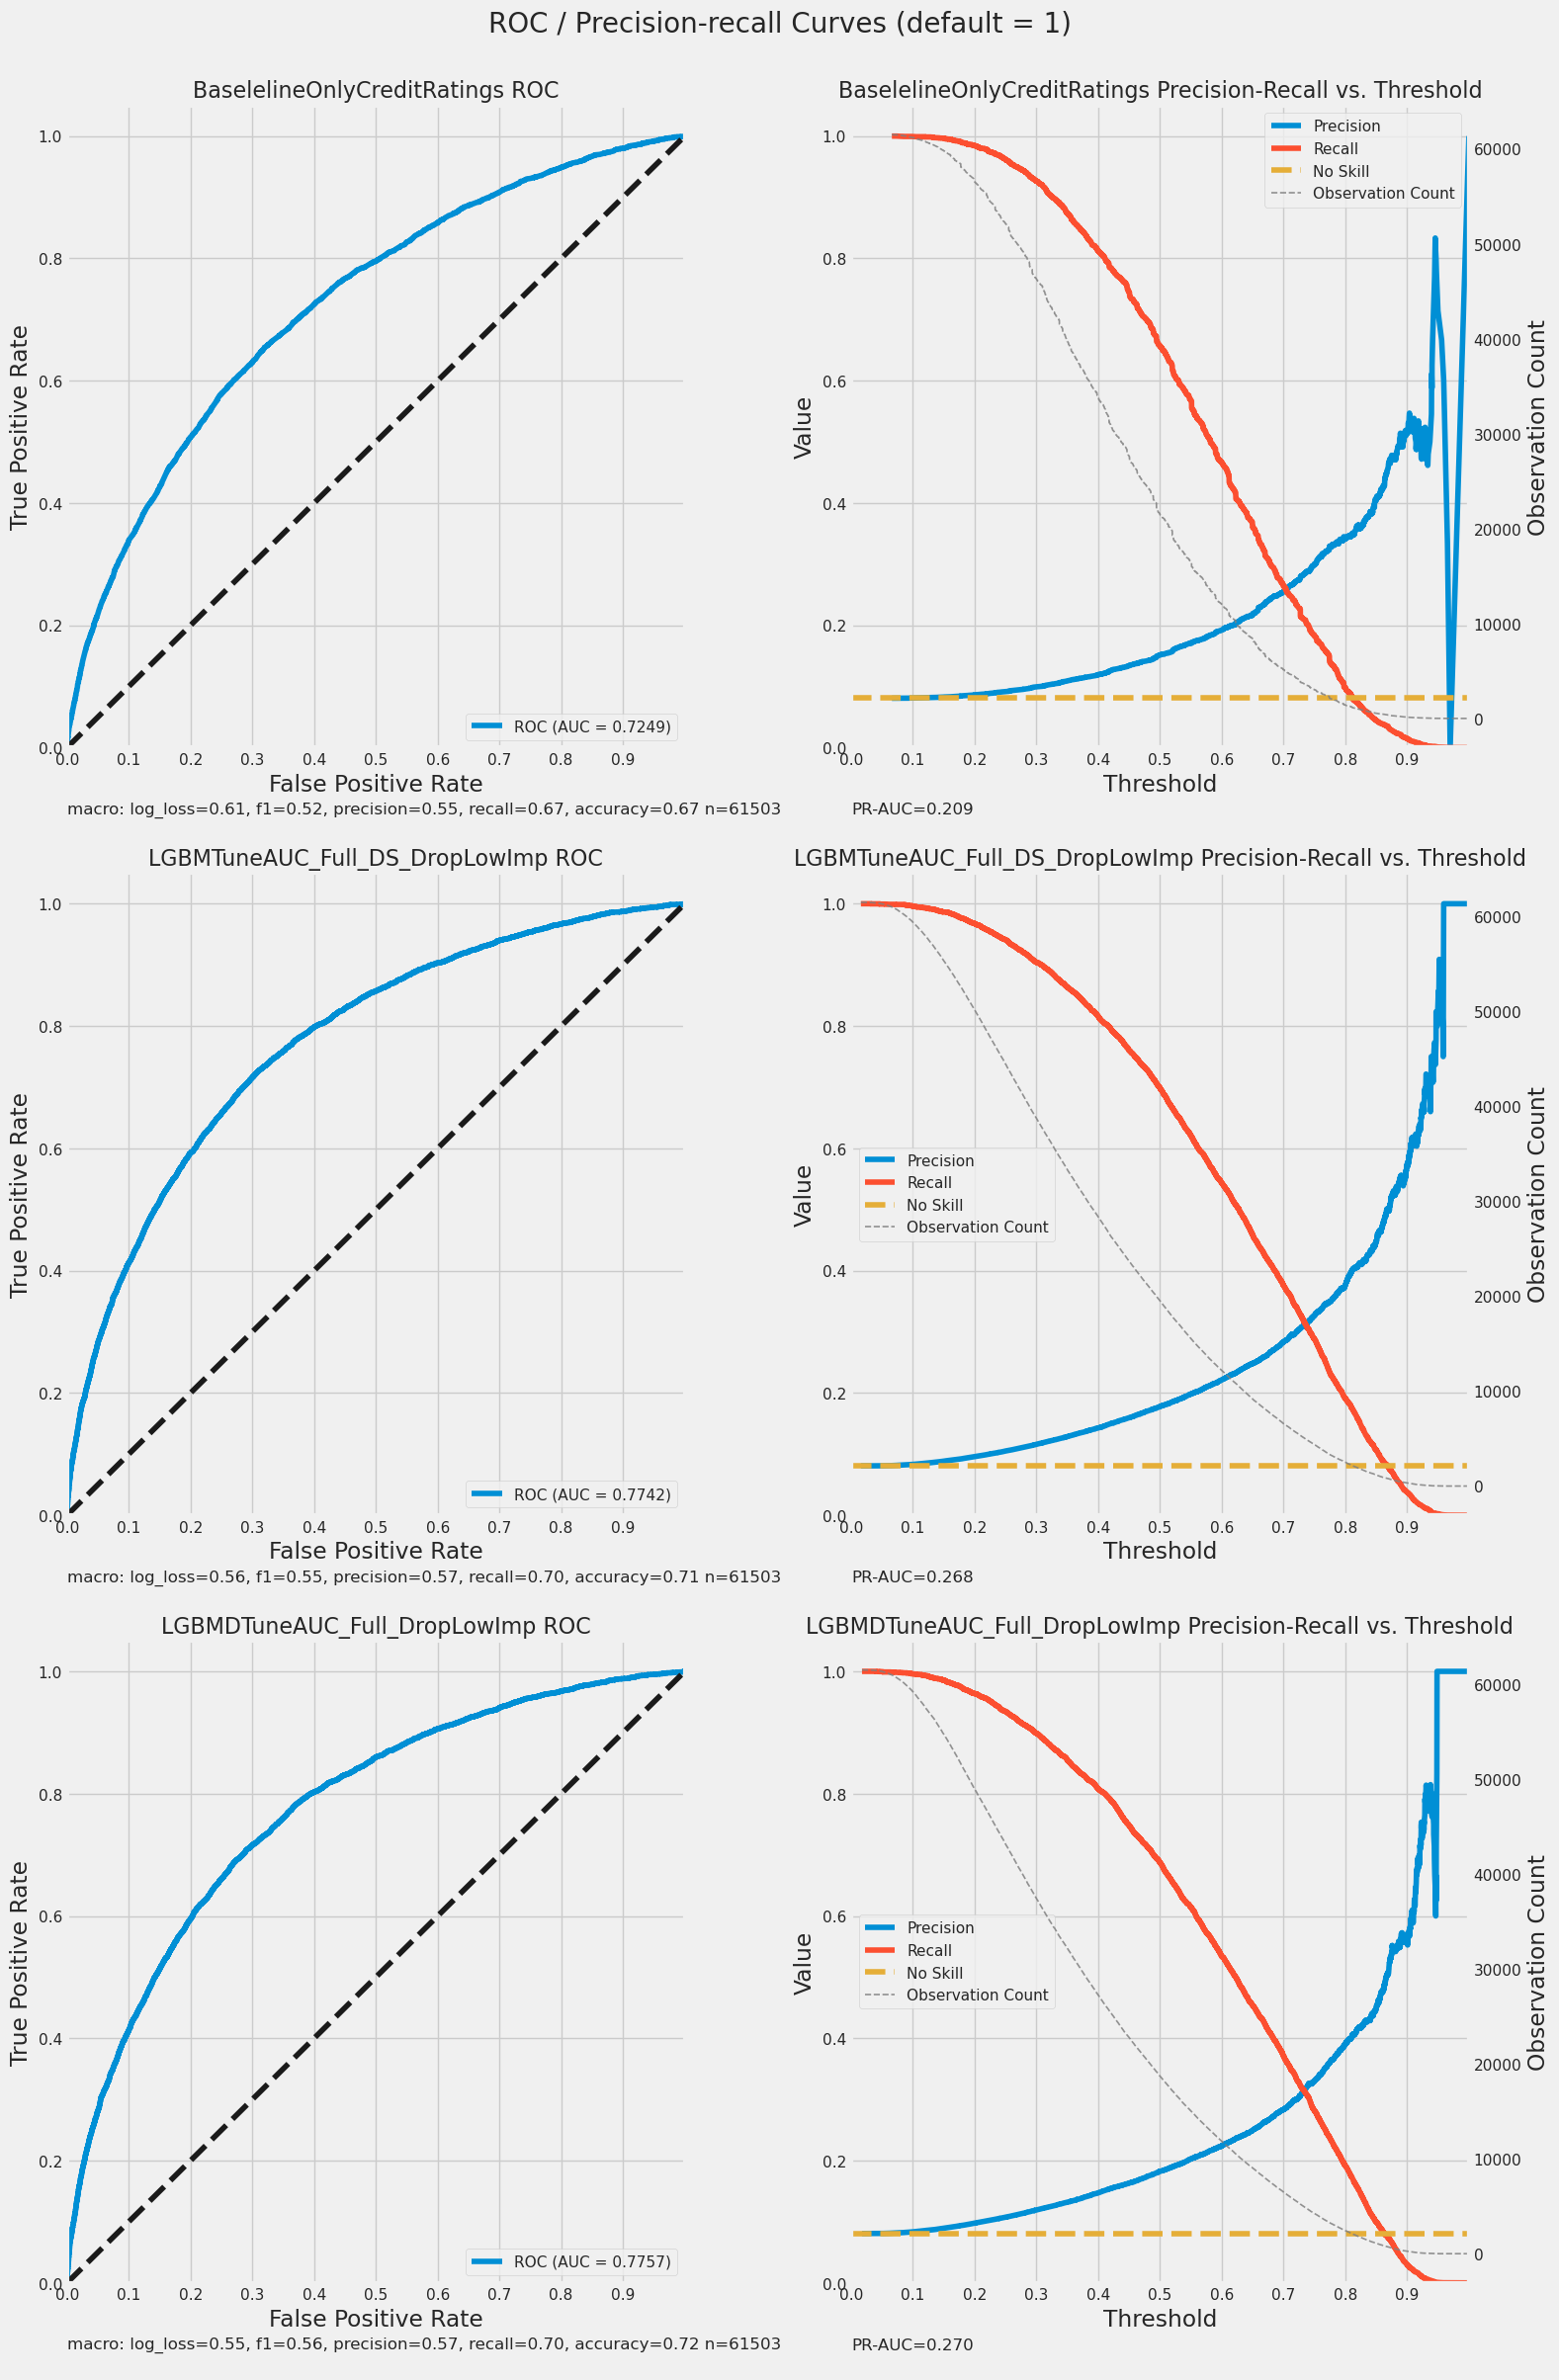

In [5]:
if len(cv_results_all_models) < 2:
    cv_results_all_models["_DUMMY"] = cv_results_all_models[list(cv_results_all_models.keys())[0]]
importlib.reload(graph)
first_model = list(cv_results_all_models.keys())[0]
graph.roc_precision_recal_grid_plot(cv_results_all_models, show_observation_count=True)

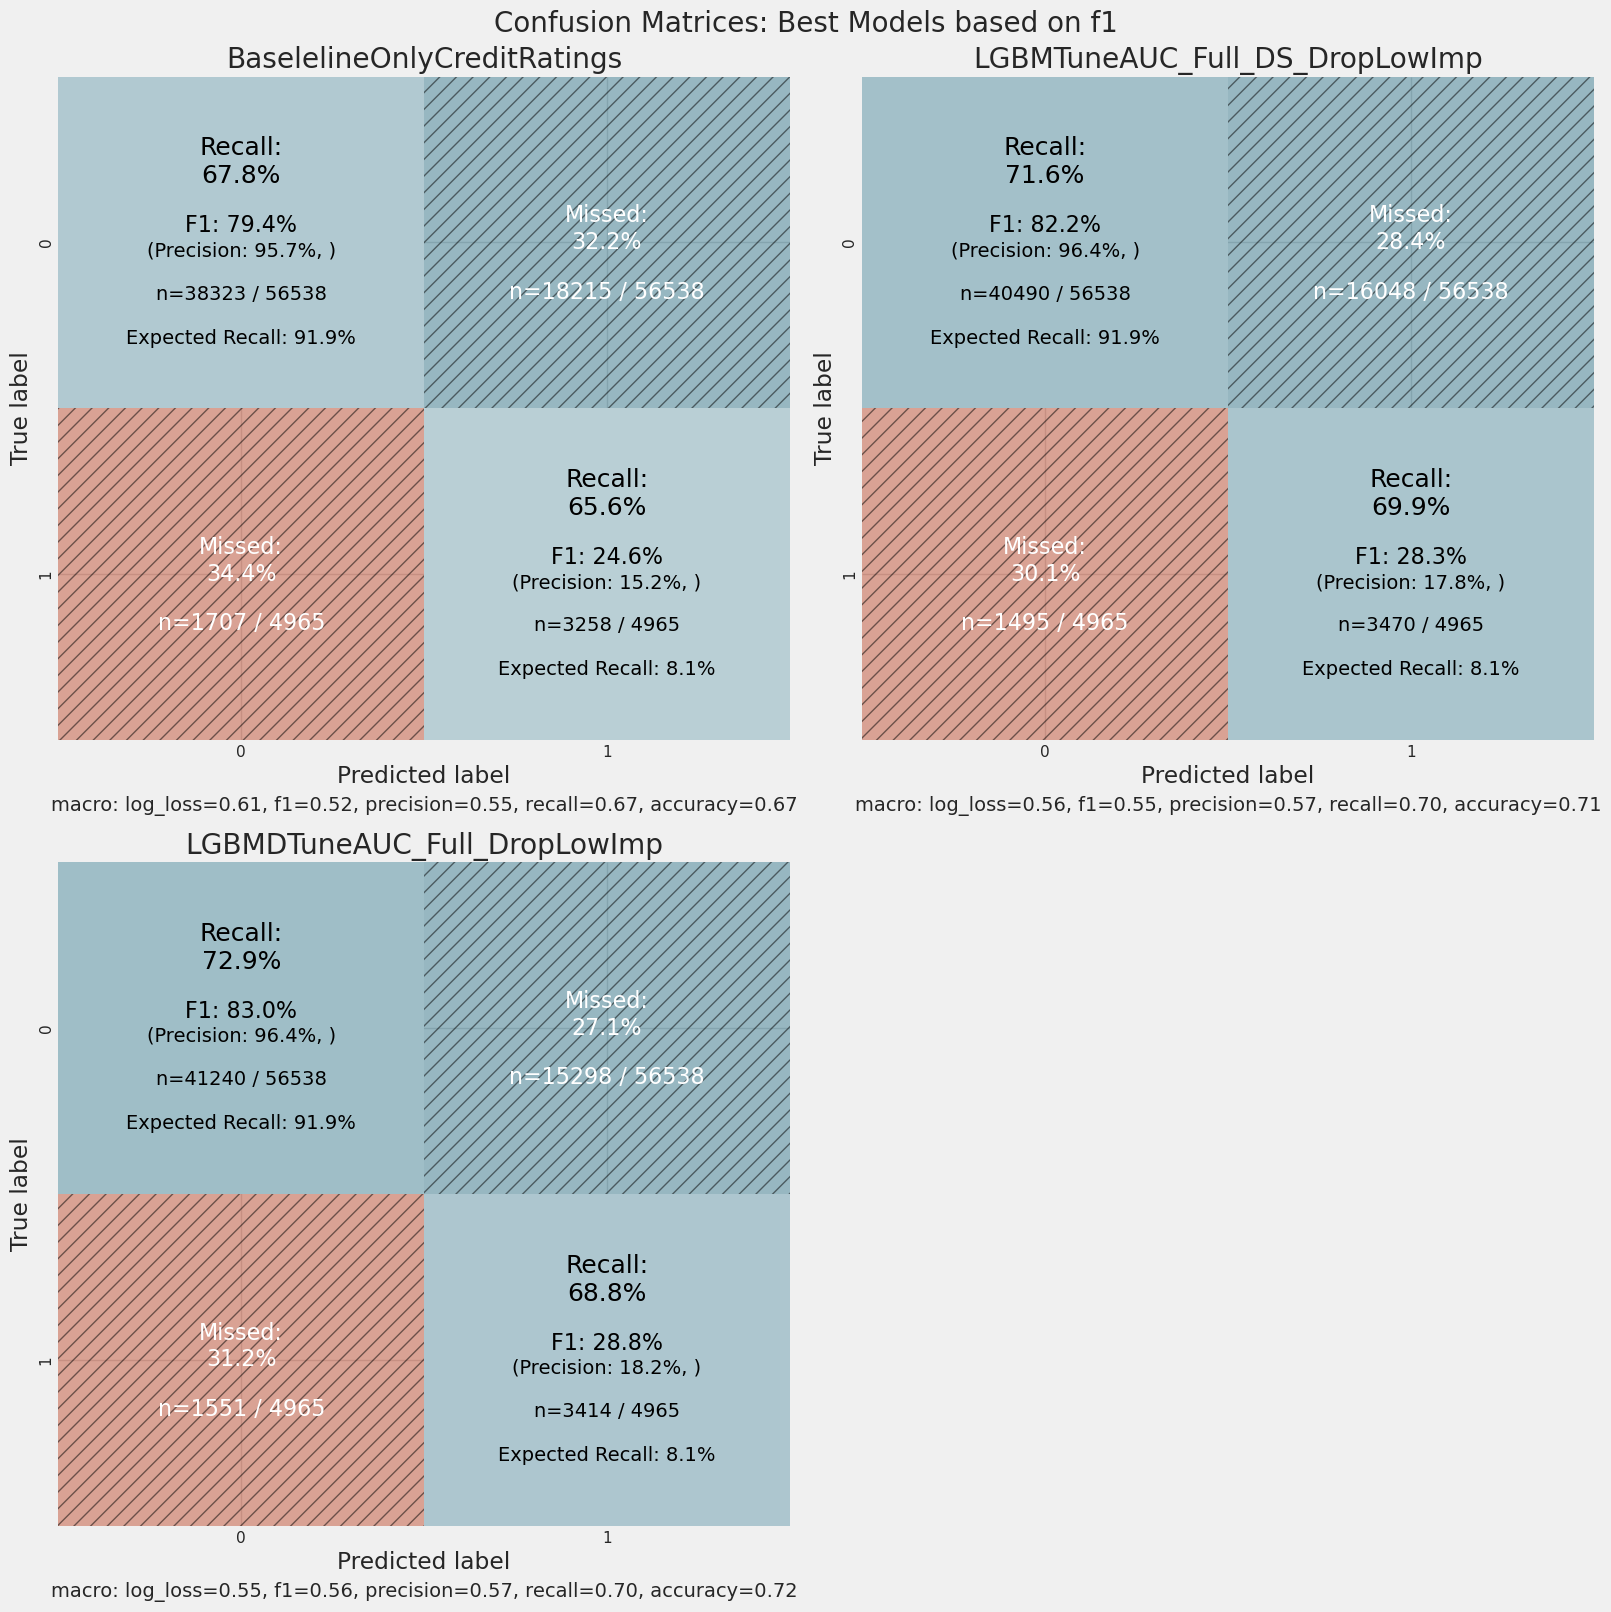

In [6]:
importlib.reload(graph)

n = len(cv_results_all_models)
columns = 2
rows = (n + 1) // columns
height = 8
width = height * columns

fig, axes = plt.subplots(
    rows, columns, figsize=(width, height * rows), constrained_layout=True
)
plt.suptitle("Confusion Matrices: Best Models based on f1", fontsize=20)

axes_flat = axes.flatten()
for i, model_key in enumerate(cv_results_all_models.keys()):
    graph.confusion_matrix_plot_v2(
        cv_results_all_models[model_key].cm_data,
        title=model_key,
        annotations=graph.make_annotations(cv_results_all_models[model_key].cv_metrics),
        ax=axes_flat[i],
    )

# Hide any unused axes
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis("off")

plt.show()

In [7]:
# importlib.reload(stats_utils)
# importlib.reload(graph)
# 
# for model_key in cv_results_all_models.keys():
#     if "Baseline" in model_key:
#         continue
#     model_config = cv_results_all_models[model_key]
#     feature_importances = stats_utils.get_model_feature_importances(
#         model_config, features_matrix
#     )
# 
#     graph.render_feature_importances_chart(
#         feature_importances=feature_importances,
#         title=f"{model_key} Importances",
#         top_n=50
#     )
#     if VERBOSE:
#         display(feature_importances)

In [8]:
# cv_results_all_models.keys()

In [9]:
from shared import pipeline

# from shared import pipeline

target_model_config = results_all_models["LGBMDTuneAUC_Full_DropLowImp"]
features_matrix = target_model_config[0].model_pipeline_config.load_data(
    loader_function=feature_builder_v2.load_datasets_and_prepare_features)
# 
features_all, labels_all = pipeline._get_features_labels(features_matrix)
X_train, X_test, y_train, y_test = pipeline.get_deterministic_train_test_split(
    features_all, labels_all
)

X_train = X_train.drop(columns=["TARGET"])
X_test = X_test.drop(columns=["TARGET"])
# 
# importlib.reload(graph)
# for model_key, model_data in cv_results_all_models.items():
#     if "Baseline" in model_key:
#         continue
# 
#     model = cv_results_all_models[model_key].test_data.test_model.named_steps["model"]
# 
#     booster_model = model.get_booster()
#     shap_values = booster_model.predict(
#         xgboost.DMatrix(X_test, enable_categorical=True), pred_contribs=True
#     )
#     graph.render_shap_plot(shap_values, X_test, model_title=model_key)

index SK_BUREAU_ID not found in dataframe, creating new integer column


Appending previous history
drop drop_cols_post_proc: 227
after drop_cols_post_proc: 121
Full DS size: 307511


In [49]:
model = target_model_config[1].test_data.test_model.named_steps["model"]


In [50]:
prob_pos = model.predict_proba(X_test)[:, 1]


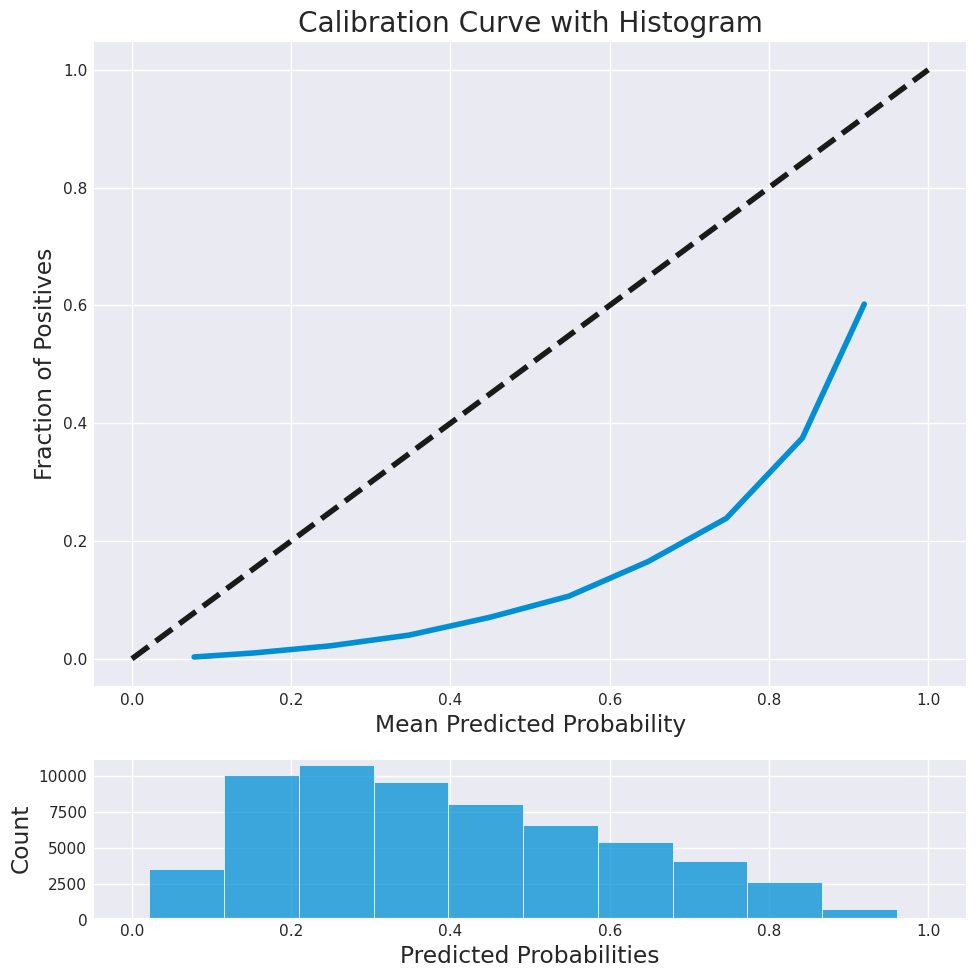

In [63]:
import numpy as np
import matplotlib.gridspec as gridspec

# Create a grid for subplots
plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

# Calibration curve plot
ax0 = plt.subplot(gs[0])
sns.lineplot(data=calibration_data, x='Predicted Probability', y='True Probability', ax=ax0)
ax0.plot([0, 1], [0, 1], 'k--')
ax0.set_title('Calibration Curve with Histogram')
ax0.set_xlabel('Mean Predicted Probability')
ax0.set_ylabel('Fraction of Positives')

# Add confidence intervals (this is illustrative; in practice, you'd calculate these)
# lower_bounds, upper_bounds = calculate_confidence_intervals(prob_pos, y_test)
# ax0.fill_between(predicted_prob, lower_bounds, upper_bounds, color='skyblue', alpha=0.3)

# Histogram plot for predicted probabilities
ax1 = plt.subplot(gs[1], sharex=ax0)
sns.histplot(prob_pos, bins=10, ax=ax1)
ax1.set_xlabel('Predicted Probabilities')
ax1.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Calculate and annotate ECE if desired
# ece = calculate_ece(prob_pos, y_test)
# ax0.annotate(f'ECE: {ece:.3f}', xy=(0.1, 0.9), xycoords='axes fraction')




The calibration curve, also known as a reliability diagram, is a graphical representation used to evaluate the accuracy of predicted probabilities in classification models. It specifically checks how well the predicted probabilities of a model match the actual outcomes.

The ideal calibration curve is a straight line at a 45-degree angle from the bottom left to the top right of the plot. This line, often called the "line of perfect calibration," indicates that the model's predictions are perfectly calibrated. If your model predicts a class with 70% probability, then 70% of the cases that are predicted as such should indeed belong to that class.

Common Patterns and Their Interpretations:
Perfect Calibration:

The points lie on the diagonal line from (0,0) to (1,1).
Example: If a model predicts an event with 30% probability, then in the long run, that event occurs about 30% of the time when predicted at this probability.
Underconfidence:

The curve lies above the diagonal line.
The model's probabilities are lower than the true likelihood of the event. For instance, if events the model predicts to happen 60% of the time actually happen 80% of the time, the model is underconfident.
Overconfidence:

The curve lies below the diagonal line.
The model predicts higher probabilities than what is true. If a prediction of 80% only happens 60% of the time, the model is overconfident.


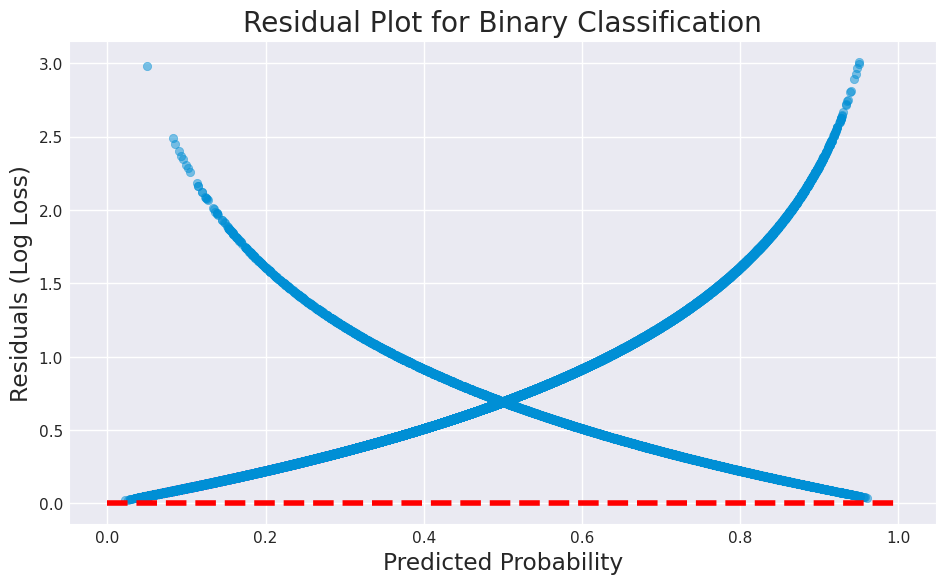

In [65]:
# Assuming y_test is your true binary labels and prob_pos are the predicted probabilities
residuals = np.where(y_test == 1, -np.log(prob_pos), -np.log(1 - prob_pos))

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(prob_pos, residuals, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=1, color='red', linestyles='--')
plt.xlabel('Predicted Probability')
plt.ylabel('Residuals (Log Loss)')
plt.title('Residual Plot for Binary Classification')
plt.show()


Plots the difference between observed and predicted probabilities. Helps in checking the assumption of homoscedasticity. Ideally, residuals should be randomly dispersed around the central line, and patterns suggest model inadequacies.


homoscedasticity


Based on the chart we see these potential problems:
Probability Estimates are Polarized:

The cup-like pattern at the top suggests the model is very confident (probabilities close to 0 or 1) about certain instances but is incorrect, as these points have higher residuals.
The bottom lines being straighter and closer to zero indicate that for a range of predicted probabilities, the residuals are consistently low, which means the model performs well in that range.

Model Overconfidence:

The residuals are larger for predictions near 0 or 1 because the log loss penalizes confident incorrect predictions more harshly than less confident ones.
This overconfidence is often characteristic of models that are not well-calibrated and could benefit from probability calibration techniques.

Class Imbalance:

This pattern can sometimes emerge from class imbalance if the model is better at predicting the majority class and frequently mispredicts the minority class with high confidence.

Non-linearity in Feature Space:

The curving pattern could also be a sign that the model is not capturing some non-linear relationships between features and the outcome. This might suggest that feature engineering or a more sophisticated model could be helpful.


#### Calibration Curve (Reliability Diagram):

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


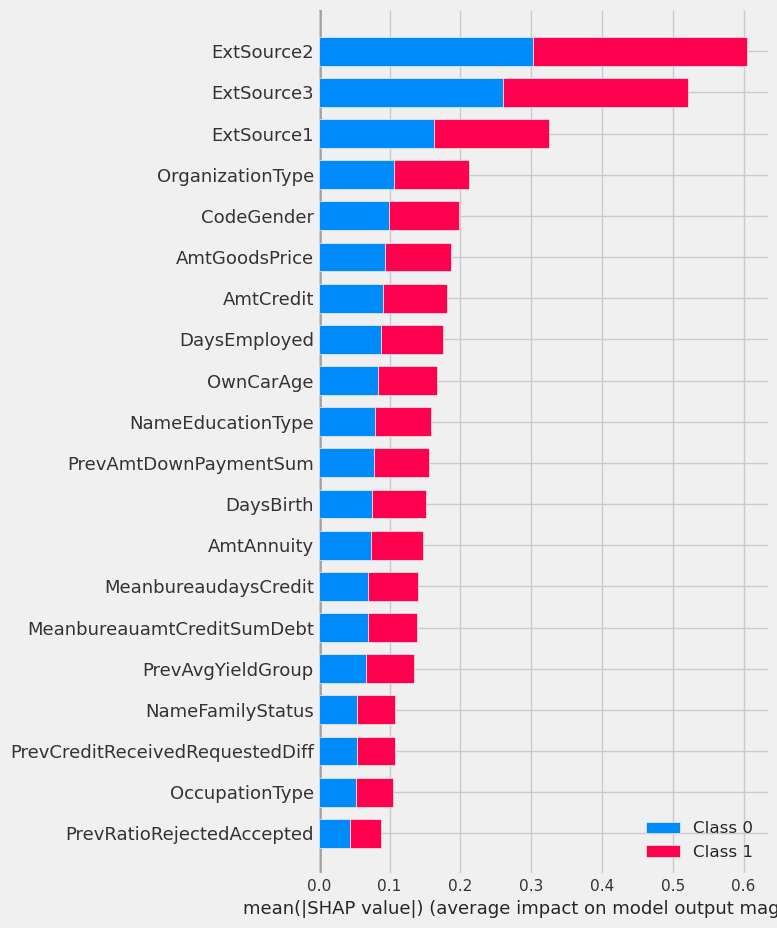

In [10]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


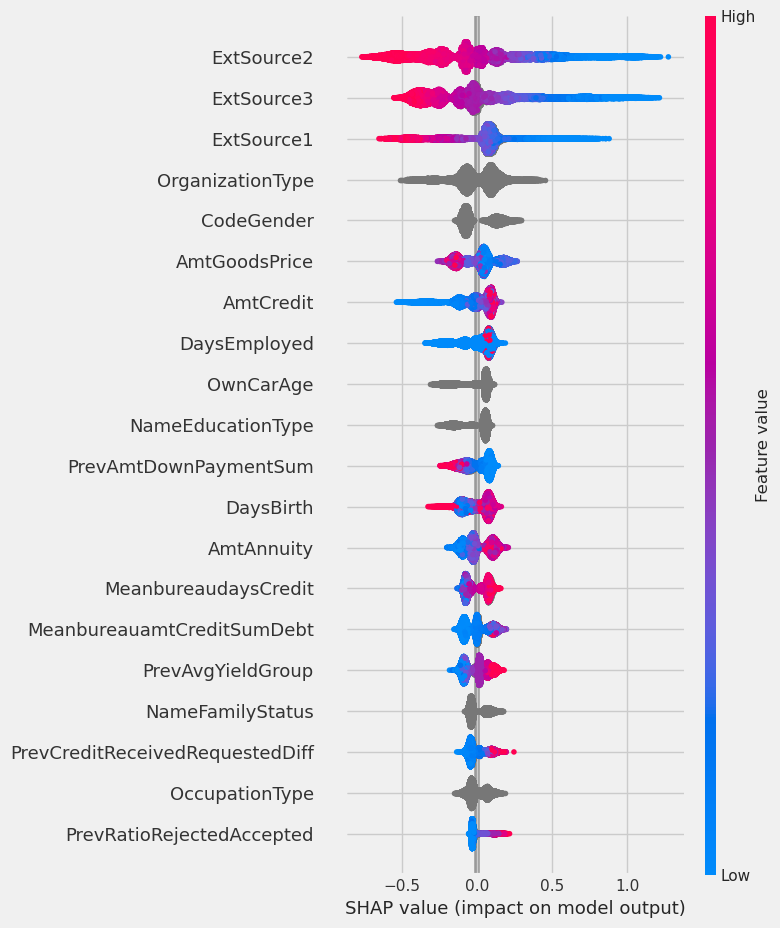

In [11]:
shap.summary_plot(shap_values[1], X_test)

In [12]:
import numpy as np

# Assuming shap_values is a list of SHAP values for a multi-class model, or a numpy array for a binary model
if isinstance(shap_values, list):  # Multi-class scenario
    # Calculate the mean absolute SHAP values for each feature across all classes
    shap_abs_mean = np.abs(np.concatenate(shap_values, axis=0)).mean(axis=0)
else:  # Binary classification or regression
    shap_abs_mean = np.abs(shap_values).mean(axis=0)

# Creating a DataFrame with feature names and their corresponding mean absolute SHAP values
feature_importances_df = pd.DataFrame(list(zip(X_test.columns, shap_abs_mean)),
                                      columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Display the DataFrame
# display(feature_importances_df)

low_imp = feature_importances_df[feature_importances_df["Importance"] < 0.002]
list(low_imp["Feature"])

['MeanbureauamtAnnuity',
 'PrevAvgNflagInsuredOnApproval',
 'CommonareaAvg',
 'LandareaAvg',
 'MaxbureauamtAnnuity',
 'YearsBuildMode',
 'RegCityNotWorkCity',
 'PrevCodeRejectReasonLimitCount',
 'EntrancesAvg',
 'EntrancesMedi',
 'NonlivingareaMedi',
 'NonlivingareaAvg']

In [48]:
high_imp = feature_importances_df[feature_importances_df["Importance"] > 0.035]
list(high_imp["Feature"])
# len(list(high_imp["Feature"]))

['ExtSource2',
 'ExtSource3',
 'ExtSource1',
 'OrganizationType',
 'CodeGender',
 'AmtGoodsPrice',
 'AmtCredit',
 'DaysEmployed',
 'OwnCarAge',
 'NameEducationType',
 'PrevAmtDownPaymentSum',
 'DaysBirth',
 'AmtAnnuity',
 'MeanbureaudaysCredit',
 'MeanbureauamtCreditSumDebt',
 'PrevAvgYieldGroup',
 'NameFamilyStatus',
 'PrevCreditReceivedRequestedDiff',
 'OccupationType',
 'PrevRatioRejectedAccepted',
 'DaysIdPublish',
 'MaxbureaudaysCreditEnddate',
 'PrevLastLoanGoodsCategory',
 'MeanbureauamtCreditMaxOverdue',
 'FlagDocument3']

In [47]:
any_imp = feature_importances_df[feature_importances_df["Importance"] > 0.01]
list(any_imp["Feature"])
# len(list(any_imp["Feature"]))

['ExtSource2',
 'ExtSource3',
 'ExtSource1',
 'OrganizationType',
 'CodeGender',
 'AmtGoodsPrice',
 'AmtCredit',
 'DaysEmployed',
 'OwnCarAge',
 'NameEducationType',
 'PrevAmtDownPaymentSum',
 'DaysBirth',
 'AmtAnnuity',
 'MeanbureaudaysCredit',
 'MeanbureauamtCreditSumDebt',
 'PrevAvgYieldGroup',
 'NameFamilyStatus',
 'PrevCreditReceivedRequestedDiff',
 'OccupationType',
 'PrevRatioRejectedAccepted',
 'DaysIdPublish',
 'MaxbureaudaysCreditEnddate',
 'PrevLastLoanGoodsCategory',
 'MeanbureauamtCreditMaxOverdue',
 'FlagDocument3',
 'MaxbureaudaysCredit',
 'MaxbureaudaysEnddateFact',
 'DaysLastPhoneChange',
 'RegionRatingClientWCity',
 'AmtReqCreditBureauQrt',
 'PrevRatioSumDownPaymentCredit',
 'MeanbureauamtCreditSum',
 'ActiveLoansCount',
 'NameContractType',
 'MaxbureauamtCreditMaxOverdue',
 'WeekdayApprProcessStart',
 'PrevLastLoanDecisionDate',
 'PrevRefusedToTotalRatio',
 'MaxbureauamtCreditSum',
 'MinbureauamtCreditSum',
 'DaysRegistration',
 'PrevHasAnyDpdMean',
 'PrevTotalDpdSum

In [15]:
import numpy as np

# Calculate absolute differences between predicted probabilities and actual values
predicted_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

absolute_differences = np.abs(predicted_probabilities - y_test)

# Create a DataFrame for easier handling
differences_df = pd.DataFrame({
    'absolute_difference': absolute_differences,
    'index': range(len(y_test))
})

# Sort by 'absolute_difference' in descending order and select the top N
N = 10
top_differences_df = differences_df.nlargest(N, 'absolute_difference')

# If you want a random sample of N from these top differences
random_sample_top_diff = top_differences_df.sample(n=N, random_state=42)  # Use a fixed seed for reproducibility

# Get the indices of the selected samples
selected_indices = random_sample_top_diff['index'].values

# Use these indices to select instances from X_test or y_test if needed
selected_samples_X_test = X_test.iloc[selected_indices]
selected_samples_y_test = y_test.iloc[selected_indices]


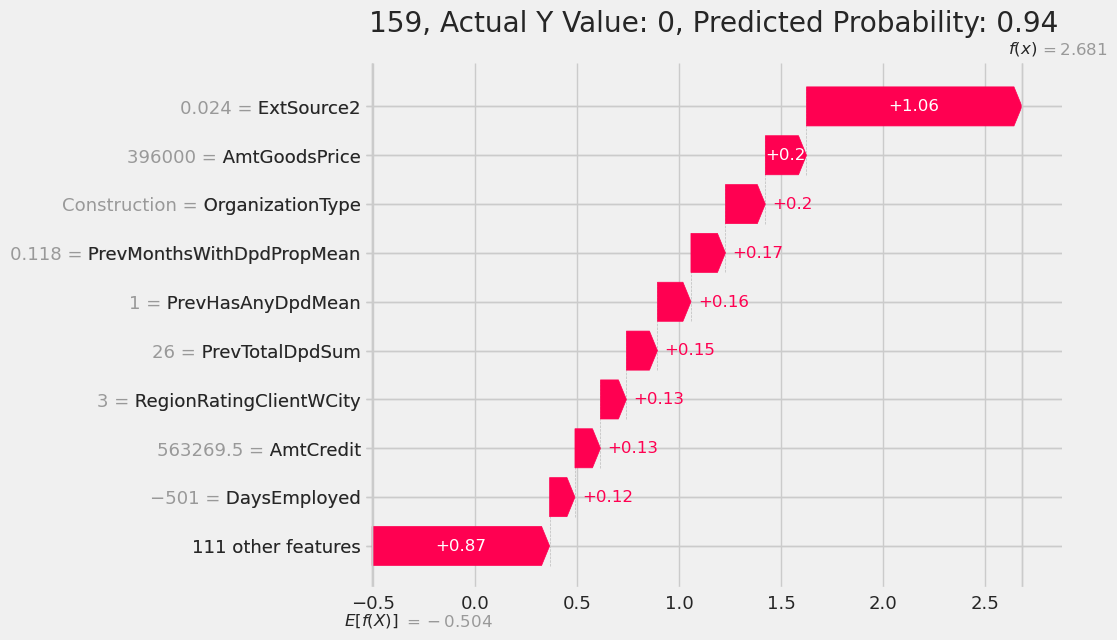

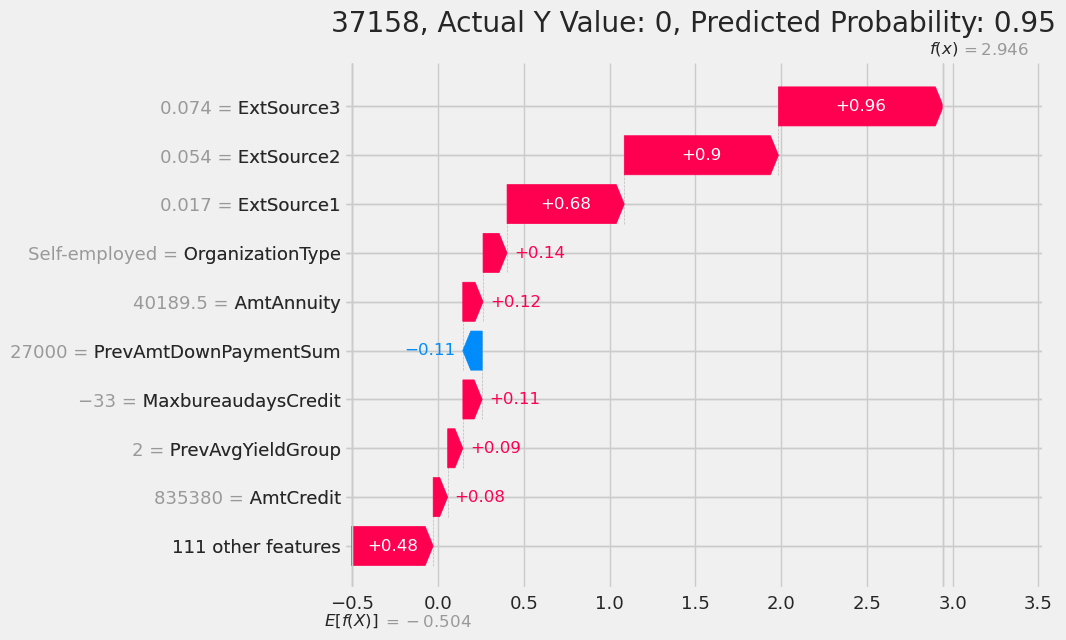

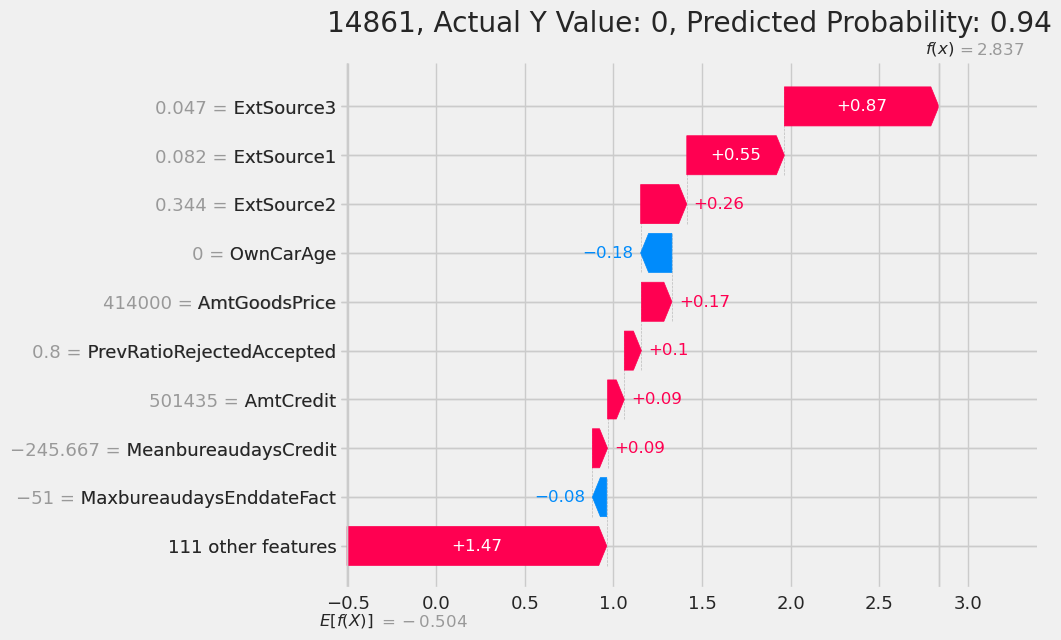

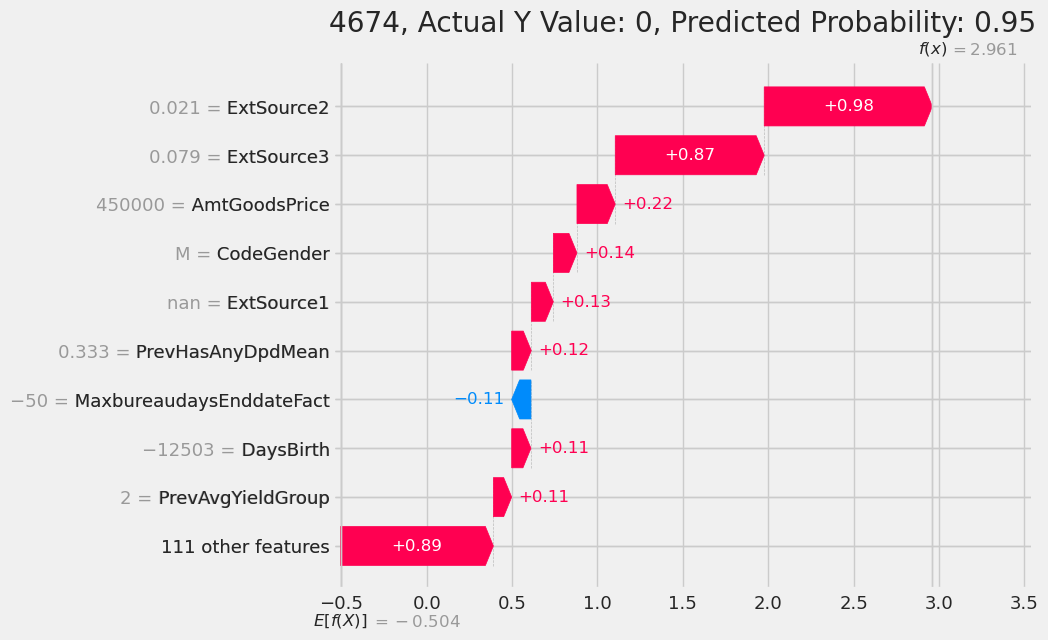

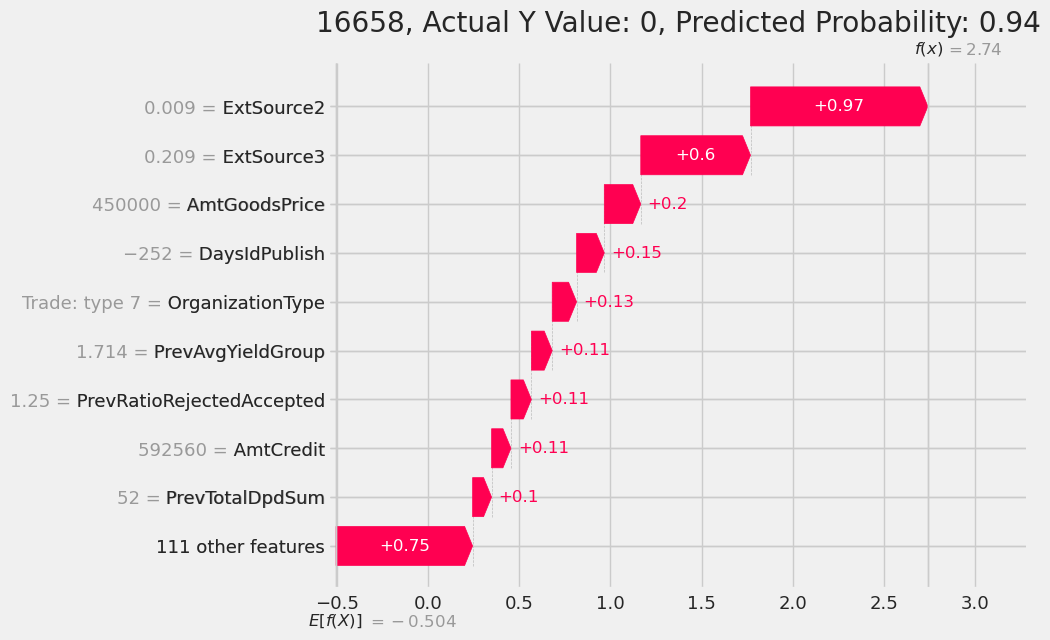

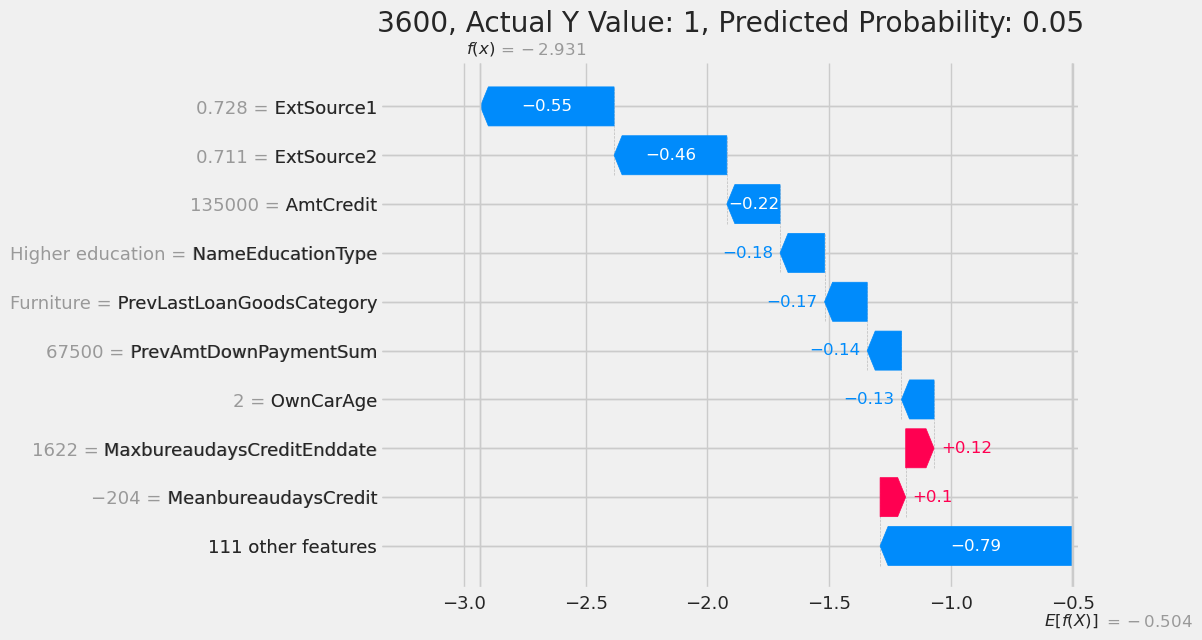

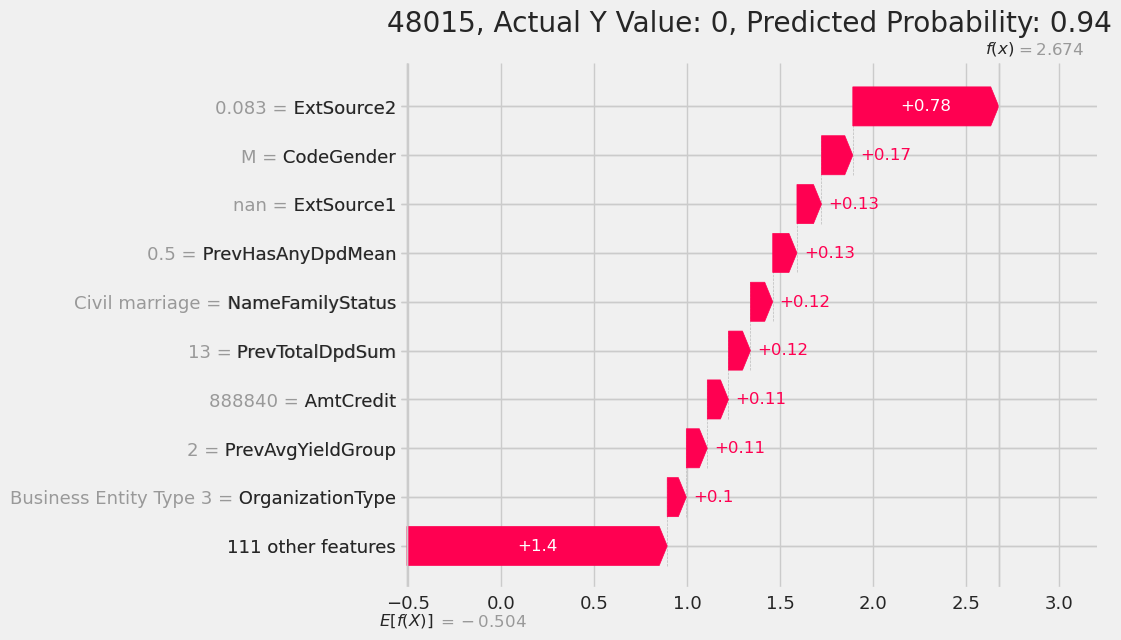

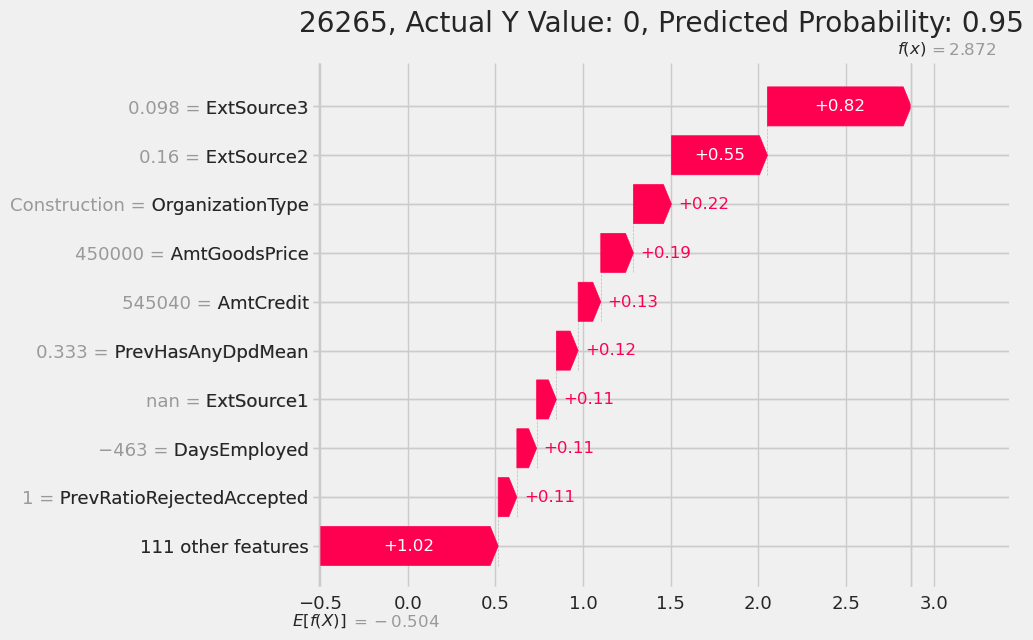

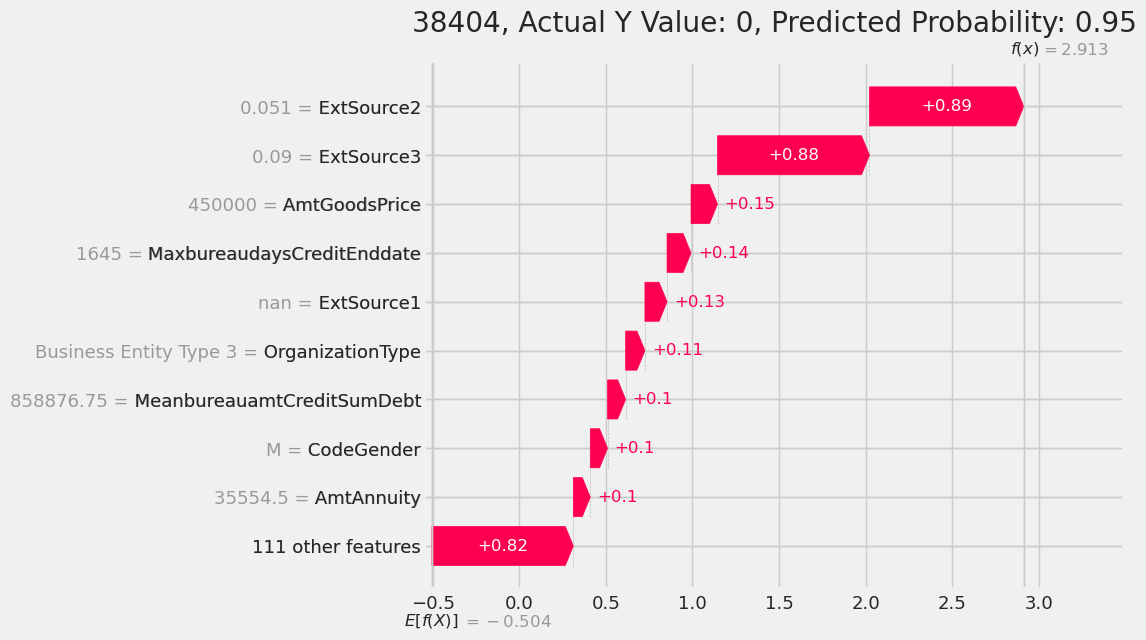

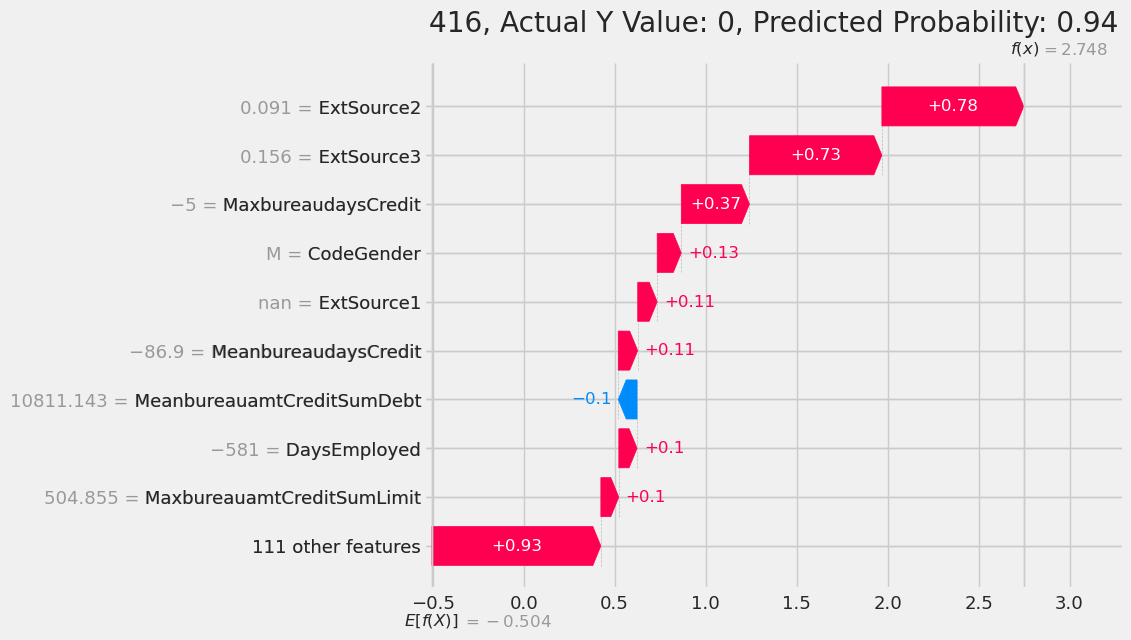

In [16]:

for i in selected_indices:
    # Create the SHAP Explanation object for the selected sample
    shap_explanation = shap.Explanation(values=shap_values[1][i],
                                        base_values=explainer.expected_value[1],
                                        data=X_test.iloc[i].values,
                                        feature_names=X_test.columns.tolist())

    # Calculate predicted probability for the selected sample
    predicted_probability = model.predict_proba(X_test.iloc[i:i + 1])[0, 1]

    # Retrieve the actual y value for the selected sample
    actual_y_value = y_test.iloc[i]

    # Generate the waterfall plot
    shap.plots.waterfall(shap_explanation, show=False)

    # Adding a title with the sample index, actual y value, and predicted probability
    plt.title(f"{i}, Actual Y Value: {actual_y_value}, Predicted Probability: {predicted_probability:.2f}")
    plt.show()


In [17]:
cm_target_model_key = "LGBMDTuneAUC_Full_DropLowImp"
cm_target_model = cv_results_all_models[cm_target_model_key]

target_cm_data = cm_target_model.test_data
target_cm_data_sorted = target_cm_data.probabilities.sort_values(by=1).reset_index(
    drop=True
)
target_cm_data_sorted
# target_cm_data_sorted["value"] = target_cm_data.y_test

,0,1
0,0.982401,0.017599
1,0.977671,0.022329
2,0.976592,0.023408
3,0.971298,0.028702
4,0.970694,0.029306
...,...,...
61498,0.051528,0.948472
61499,0.051178,0.948822
61500,0.048181,0.951819
61501,0.042986,0.957014


In [18]:
prediction_data = target_cm_data.probabilities.copy()
prediction_data["value"] = target_cm_data.y_test

In [19]:
prediction_data

,0,1,value
256571,0.621298,0.378702,0
191493,0.758006,0.241994,0
103497,0.203189,0.796811,0
130646,0.538224,0.461776,0
211898,0.447241,0.552759,0
...,...,...,...
16213,0.617676,0.382324,0
294620,0.421354,0.578646,0
234384,0.827813,0.172187,0
149027,0.394925,0.605075,1


In [20]:
target_cm_data.probabilities

,0,1
256571,0.621298,0.378702
191493,0.758006,0.241994
103497,0.203189,0.796811
130646,0.538224,0.461776
211898,0.447241,0.552759
...,...,...
16213,0.617676,0.382324
294620,0.421354,0.578646
234384,0.827813,0.172187
149027,0.394925,0.605075


In the finance industry, loan grades (or credit scores) are a crucial part of risk management, helping lenders assess the creditworthiness of borrowers. These grades are typically determined based on various factors, including the borrower's credit history, income stability, debt-to-income ratio, and more. The grades reflect the estimated risk of default, and they directly influence the interest rate offered to the borrower. Commonly, loan grades are categorized from 'A' (lowest risk) to 'G' (highest risk), although the specific categories can vary by institution.

A (Lowest Risk): Below 1% default rate. Borrowers with excellent credit histories and very low risk of default.
B: 1% to 3% default rate. Borrowers with good credit histories and low risk of default.
C: 3% to 7% default rate. Borrowers with average credit histories and moderate risk of default.
D: 7% to 15% default rate. Borrowers with below-average credit histories and higher risk of default.
E: 15% to 25% default rate. Borrowers with poor credit histories and very high risk of default.
F and G (Highest Risk): Above 25% default rate. Borrowers with very poor credit histories and extremely high risk of default.



In [21]:
# Assuming source_df_grades_summary and target_cm_data are already defined
# Sort probabilities for cumulative proportion mapping

# Define the data as a dictionary
data = {
    "index": ["A", "B", "C", "D", "E", "F", "G"],
    "Proportion": [0.12, 0.14, 0.17, 0.14286, 0.14286, 0.14286, 0.14286],
    "Loan_Status_Ratio": [1, 1, 1, 1, 1, 1, 1]
}

# Convert the dictionary to a DataFrame
source_df_grades_summary = pd.DataFrame(data)

# Set the 'index' column as the index of the DataFrame
source_df_grades_summary = source_df_grades_summary.set_index('index')

source_df_grades_summary["Cumulative"] = source_df_grades_summary["Proportion"].cumsum()
source_df_grades_summary["Cumulative"] = source_df_grades_summary["Cumulative"].clip(
    upper=1
)

sections = []

palette = sns.color_palette("YlOrRd", n_colors=len(source_df_grades_summary))

start_color = "grey"
colors = (
        [start_color] + palette + ["red"]
)  # Ensure "red" is used for the merged EFG section

i = 0
previous_cumulative = 0

# efg_weights = source_df_grades_summary.loc["E":"G", "Counts"]
# efg_risks = source_df_grades_summary.loc["E":"G", "Loan_Status_Ratio"]
# weighted_avg_risk_efg = np.average(efg_risks, weights=efg_weights)

# Find thresholds in target_cm_data that match cumulative proportions
for grade, row in source_df_grades_summary.iterrows():
    if grade == source_df_grades_summary.index[0]:
        start = 0.0
    else:
        start = target_cm_data_sorted[1].quantile(previous_cumulative)

    end = target_cm_data_sorted[1].quantile(row["Cumulative"])

    #  merge grades E, F, G
    # if grade == "E":
    #     continue
    # elif grade == "F":
    #     continue
    # elif grade == "G":
    #     label = "E-F-G Grade"
    #     color = "red"
    # else:
    if True:
        label = f"{grade} Grade"
        color = colors[i]

    # if grade == "G":
    #     description = f"Expected D. R.: {weighted_avg_risk_efg:.1%}"
    # else:
    #     description = f"Expected D. R.: {row['Loan_Status_Ratio']:.1%}"

    sections.append(
        {
            "label": label,
            "start": start,
            "end": end,
            "color": color,
            "description": "",
        }
    )
    if grade != "G":
        i += 1
    previous_cumulative = row["Cumulative"]
sections[-1]["end"] = 1.35
# sections




[{'label': 'A Grade', 'start': 0.0, 'end': 0.14572823526319395, 'color': 'grey', 'description': 'Default rate up to 1%'}, {'label': 'B Grade', 'start': 0.14572823526319395, 'end': 0.3669797442047051, 'color': (0.996078431372549, 0.8497808535178777, 0.46145328719723183), 'description': 'Default rate up to 3%'}, {'label': 'C Grade', 'start': 0.3669797442047051, 'end': 0.5311321024201682, 'color': (0.9920953479430988, 0.5490657439446367, 0.23418685121107266), 'description': 'Default rate up to 7%'}, {'label': 'D Grade', 'start': 0.5311321024201682, 'end': 0.76523226719004, 'color': (0.8866897347174163, 0.09956170703575548, 0.11072664359861592), 'description': 'Default rate up to 15%'}, {'label': 'E-F-G Grade', 'start': 0.76523226719004, 'end': 1.0, 'color': 'red', 'description': 'Default rate up to 100%'}]


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


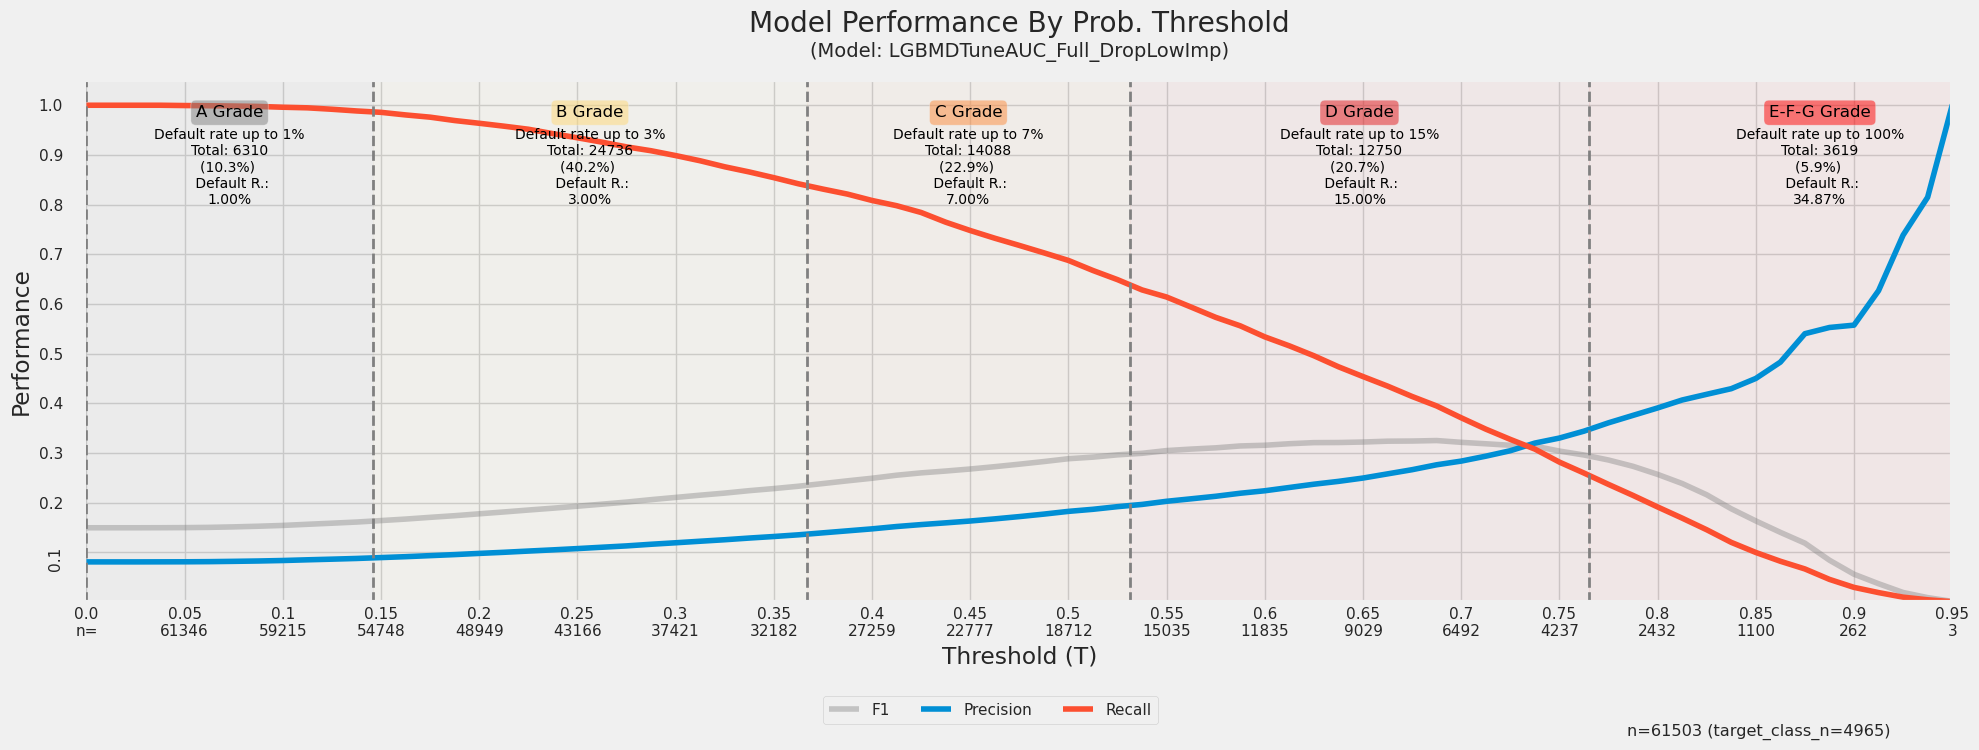

`The chart shows the  performance of the if only individual with stroke Prob. > T are selected. Additionally the overlay indicates the number of people whose predicted P is in an given range. The overlays can be used to selected the most at risk individual based on the probability predicted for them`

In [22]:
import numpy as np
import pandas as pd


# def calculate_thresholds(prediction_data: pd.DataFrame) -> list:
#     # Default rates dictionary included within the function
#     default_rates = {'A': 0.01, 
#                      'B': 0.03, 
#                      'C': 0.07,
#                      'D': 0.15, 
#                      'E-F-G': 1}
#                      # 'E': 0.25,
#                      # 'F': 0.35, 
#                      # 'G': 1.0}
#     
#     palette = sns.color_palette("YlOrRd", n_colors=len(default_rates))
#     
#     start_color = "grey"
#     colors = (
#         [start_color] + palette + ["red"]
#     )  # Ensure "red" is used for the merged EFG section
# 
#     # Prepare the data
#     prediction_data_sorted = prediction_data.sort_values(by=1, ascending=True)
#     prediction_data_sorted['cumulative_default'] = prediction_data_sorted['value'].cumsum()
#     prediction_data_sorted['cumulative_non_default'] = np.arange(1, len(prediction_data_sorted) + 1) - prediction_data_sorted['cumulative_default']
#     prediction_data_sorted['default_rate'] = prediction_data_sorted['cumulative_default'] / (prediction_data_sorted['cumulative_non_default'] + prediction_data_sorted['cumulative_default'])
# 
#     # Initialize the list to store sections
#     sections = []
#     start = 0.0  # Initial start value
#     
#     i = 0
#     for grade, rate in default_rates.items():
#         # Identify the threshold for the current grade
#         mask = prediction_data_sorted['default_rate'] <= rate
#         if mask.any():
#             max_prob = prediction_data_sorted.loc[mask, 1].max()
#             end = max_prob
#         else:
#             end = 1.0
#         
#         
#         
#         # Append the section
#         sections.append({
#             "label": f"{grade} Grade",
#             "start": start,
#             "end": end,
#             "color": colors[i],
#             "description": f"Default rate up to {rate:.1%}"
#         })
#         
#         i+=1
#         start = end  # Update start for the next grade
#     
#     # Ensure the last section end is set correctly
#     if sections:
#         sections[-1]['end'] = 1.0
#     
#     return sections
# 
# # Assuming prediction_data is defined
# Example usage 
def calculate_thresholds(prediction_data: pd.DataFrame) -> list:
    # Default rates dictionary is now internal to the function
    default_rates = {'A': 0.01, 'B': 0.03, 'C': 0.07, 'D': 0.15, 'E-F-G': 1.0}
    # default_rates = {'A': 0.01, 'B': 0.03, 'C': 0.07, 'D': 0.15, 'E': 0.25, 'F': 0.35, 'G': 1.0}

    # Adjust the color palette as specified
    palette = sns.color_palette("YlOrRd", n_colors=len(default_rates) - 2)
    start_color = "grey"
    colors = [start_color] + palette + ["red"]

    # Sort by predicted probability of default
    prediction_data_sorted = prediction_data.sort_values(by=1, ascending=True)

    sections = []
    previous_threshold = 0.0
    color_index = 0

    for grade, max_default_rate in default_rates.items():
        # Filter data for loans not yet assigned to a more secure grade
        remaining_loans = prediction_data_sorted[prediction_data_sorted[1] > previous_threshold]

        # Calculate cumulative defaults and loans for remaining loans
        remaining_loans['cumulative_defaults'] = remaining_loans['value'].cumsum()
        total_loans = np.arange(1, len(remaining_loans) + 1)
        remaining_loans['default_rate'] = remaining_loans['cumulative_defaults'] / total_loans

        # Find the threshold where the default rate exceeds the grade's max default rate
        valid_loans = remaining_loans[remaining_loans['default_rate'] <= max_default_rate]
        if not valid_loans.empty:
            threshold = valid_loans[1].max()
        else:
            # If no loans meet the criteria, the threshold is the previous threshold
            threshold = previous_threshold

        # Append section with calculated thresholds and color
        sections.append({
            "label": f"{grade} Grade",
            "start": previous_threshold,
            "end": threshold,
            "color": colors[color_index],
            "description": f"Default rate up to {max_default_rate * 100:.0f}%"
        })

        # Update for the next iteration
        previous_threshold = threshold
        color_index += 1

    # Ensure the last section goes up to 1
    if sections:
        sections[-1]['end'] = 1.0

    return sections


sections = calculate_thresholds(prediction_data)
print(sections)
importlib.reload(stats_utils)
importlib.reload(graph)
summary_desc = "`The chart shows the  performance of the if only individual with stroke Prob. > T are selected. Additionally the overlay indicates the number of people whose predicted P is in an given range. The overlays can be used to selected the most at risk individual based on the probability predicted for them`"
from IPython.core.display import Markdown

graph.plot_threshold_metrics_v2(
    target_cm_data,
    0,
    1,
    sections=sections,
    model_name=cm_target_model_key,
    class_pos=1,
    include_vars=["f1", "precision", "recall"],
    show_threshold_n=True,
    log_x=False,
)
display(Markdown(summary_desc))

In [23]:
x = target_model_config
print(1)

1


In [24]:
target_model_config[1].test_model.predict_proba()

AttributeError: 'ModelTrainingResult' object has no attribute 'test_model'

In [ ]:
### EXPORT TEST SET

test_df  = feature_builder_v2.load_datasets_and_prepare_features(**{**target_model_config[0].model_pipeline_config.data_loader_params, "ds_source":feature_builder_v2.TargetDataset.TEST, "ds_type" : feature_builder_v2.DatasetType.FULL, "drop_meta_data":False})



In [ ]:
test_df_no_id = test_df.drop(columns=["SkIdCurr"])
test_predictions = target_model_config[1].test_data.test_model.predict_proba(test_df_no_id)
test_ids = test_df["SkIdCurr"]
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions[:, 1]})

submission.to_csv('LGBM_d_v3_submission.csv', index=False)